# $$ AI \space Democracy - A\space case\space study\space on\space corruption\space citations $$

---

<p align="justify">A corrupção é a barreira número #1 ao desenvolvimento e o motor  principal da desigualdade em Portugal. Nesse sentido, propomos o uso de ferramenteas de análise de dados e de PLN para extrair, processar e abstrair informações relevantes no âmbito da corrupção em Portugal.</p>

<p align="justify"> A ideia principal é dessenvolver ferramentas que permitam ao público geral a possibilidade de acompanhar e seguir os passos políticos dos seus representandes dentro do Parlamento, de uma forma fácil e acessível a todos através de uma interface de visualização gráfica clara dos dados. </p>

In [1]:
#@title #**Importando bibliotecas principais** {run: "auto", display-mode: "form" }

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import bokeh
import re
import time
from IPython.core.display import display, HTML
import os
from matplotlib.colors import *
import matplotlib.image as mpimg
import matplotlib as mpl
import copy
import imageio
import math
from IPython.display import Image
import PIL

def color_text(text, color):
    colors = {
        "r" : "#F00",
        "g" : "#0F0",
        "b" : "#00F",
        "y" : "#FF0",
        "c" : "#0FF",
        "p" : "#F0F",
    }

    css_str = '<style>.Color{color:' + colors[color] +';}</style>'
    html_str = '<div class="Color"><b>' + text + '</b></div>'
    html = HTML(css_str + html_str)
    display(html)
    display(HTML(""))

time.sleep(0.3)
color_text('Concluído com sucesso!', 'g')

In [2]:
#@title #**Selecione um set de keywords:** {run: "auto", display-mode: "form" }

def get_derivatives(keywords):
    if keywords != "Corrupcao":
        color_text('Alerta: Atualmente nosso banco de palavras só conta com o tema "Corrupção"!', 'y')
    else:
        color_text('Concluído com sucesso!', 'g')
    return ['corrup']

keywords = "Corrupcao" #@param ["Corrupcao", "Meio Ambiente", "Educacao", "Saude"]

corruption_words = get_derivatives(keywords)

In [3]:
#@title #**Selecione um intervalo de datas de 2020-09-17 até 2021-02-26:** {run: "auto", display-mode: "form" }

date_start = "2020-09-17" #@param{type: "date"}
date_final = "2020-12-15"#@param{type: "date"}
    
def validate_dates(date_start, date_final):
    if date_start < "2020-09-17":
        color_text('Input de data inválido: Datas válidas começam em 2020-09-17', 'r')
        return None, None
    elif date_final > "2021-02-26":
        color_text('Input de data inválido: Datas válidas terminam em 2021-02-26', 'r')
        return None, None
    elif date_start > date_final:
        color_text('Aviso: Parece que você inverteu a ordem das datas, foi corrigido para você', 'y')
        temp = date_start
        date_start, date_final = date_final, date_start
        return date_start, date_final
    else:
        color_text('Sucesso', 'g')
        return date_start, date_final

date_start, date_final = validate_dates(date_start, date_final)

In [4]:
#@title #**Carregando dados** {run: "auto", display-mode: "form" }

projects = pd.read_csv("/content/projetos_assembleia.csv")
dialogs =  pd.read_csv("/content/atas_com_subject.csv")
dialogs.drop('Unnamed: 0', axis=1, inplace=True)

def find_words(data_frame, fields, words):
    series = [data_frame[field] for field in fields]
    positions = pd.DataFrame()
    for serie in series:
        for word in words:
            positions[serie.name+'_'+word+"_pos"] = serie.str.lower().str.find(word)
    return positions

def get_citations(data_frame, fields, words):
    positions = find_words(data_frame, fields, words)
    out_list = [] # pd.DataFrame(columns = data_frame.columns)
    i = 0
    for ind in positions.index:
        has_found = False
        for field_word in positions:
            if (positions[field_word][ind] != -1):
                has_found = True
                break
        if(has_found):
            #print(data_frame.iloc[ind].values)
            out_list.append(data_frame.iloc[ind].values)
            i = i + 1
    return pd.DataFrame(out_list, columns = data_frame.columns)

def get_related(full_dataframe, citation_dataframe, key_fields):
    citation_dataframe['key'] = citation_dataframe[key_fields[0]]
    full_dataframe['key'] = full_dataframe[key_fields[0]]
    for i in range(1, len(key_fields)):
        citation_dataframe['key'] = citation_dataframe['key'] + citation_dataframe[key_fields[i]]
        full_dataframe['key'] = full_dataframe['key'] + full_dataframe[key_fields[i]]
    topics = citation_dataframe['key'].unique()
    #print(topics)
    to_out = pd.DataFrame(columns = full_dataframe.columns)
    for topic in topics:
        to_out = to_out.append(full_dataframe.loc[full_dataframe['key'] == topic])
    return to_out

def get_related_projects(citations_df, projects_df):
    #print(citations_df['Subject'].unique())
    to_out = pd.DataFrame(columns = projects_df.columns)
    for subject in [str(sub) for sub in citations_df['Subject'].unique()]:
        #print('subject', subject)
        titles = subject.split(', ')
        for title in titles:
            to_out = to_out.append(projects_df.loc[projects_df['title'] == title])
    return to_out

def clean(citations):
    not_politicians = ['Presidente', 'Secretária', 'Secretário', 'Ministra', 'Ministro']
    for not_politician in not_politicians:
        citations.loc[citations['Person'].str.contains(not_politician), 'Party'] = np.nan
    citations.dropna(axis=0, inplace=True)
    citations.replace(to_replace='Partido Socialista', value='PS', inplace=True)
    citations.replace(to_replace='SD', value=np.nan, inplace=True)
    citations.replace(to_replace='N insc.', value=np.nan, inplace=True)   
    return citations

direct_citations = clean(get_citations(dialogs, ['Text'], corruption_words))
direct_projetc = get_citations(projects, ['description'], corruption_words)
indirect_citations = clean(get_related(dialogs, direct_citations, ['Date', 'Subject']))
indirect_projects = get_related_projects(direct_citations, projects)

def load_infos(custom_info_dict=None):
    if custom_info_dict == None:
            infos = {
                'PS'     : {
                    'color' : '#FF66FF',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido4_0.gif',
                    'coordinates' : (-2.5, 3.1),
                },
                'PSD'    : {
                    'color' : '#F68A21',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido3_1.gif',
                    'coordinates' : (1.6, -1),
                },
                'BE'     : {
                    'color' : '#D21F1B',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido14_0.gif',
                    'coordinates' : (-3.5, 0.5),
                },
                'PCP'    : {
                    'color' : '#FF0000',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido1_0.gif',
                    'coordinates' : (-3.5, -4.7),
                },
                'CDS-PP' : {
                    'color' : '#0091DC',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido2_0.gif',
                    'coordinates' : (2.5, -2.1),
                },
                'PAN'    : {
                    'color' : '#036A84',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/pan_2014.jpg',
                    'coordinates' : (-3.4, 3.2),
                },
                'PEV'    : {
                    'color' : '#73BE43',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido10_0.gif',
                    'coordinates' : (-2.1, -2.5),
                },
                'CH'     : {
                    'color' : '#333399',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido_chega.png',
                    'coordinates' : (5, -3.6),
                },
                'IL'     : {
                    'color' : '#00AEEE',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido_liberal.png',
                    'coordinates' : (1, 0.5) #???,
                },
                'JPP'    : {
                    'color' : '#0E766D',
                    'orientation' : 'Centro',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido_jpp.jpg',
                    'coordinates' : (0, 0) #???,
                },
                'PPM'    : {
                    'color' : '#014A94',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido5_0.gif',
                    'coordinates' : (1.25, -2.1) #???,
                },
                'NC'     : {
                    'color' : '#FEAB19',
                    'orientation' : 'Direita',
                    'url_image' : 'http://www.cne.pt/sites/default/files/partido_nos_cidadaos.jpg',
                    'coordinates' : (0, 0.9) #???,
                },
                'L'      : {
                    'color' : '#98C75A',
                    'orientation' : 'Esquerda',
                    'url_image' : 'http://www.cne.pt/sites/default/files/livre.png',
                    'coordinates' : (-4.6, 2.7),
                },
            }
            return infos
    else:
        return custom_info_dict

def carregamento():
    bar = "|" + "-"*32 + "|"
    wait = list(np.random.rand(10))

    print("Collecting Databases from the origin", '\n')

    for i in range(10):
        bar = bar.replace('-', '█', 3)
        print('\t', bar + str(i*10) + "%")
        time.sleep(wait[i])
    print('\t', "|████████████████████████████████|100%", '\n')
    color_text('Successfully load Minutes_Database.csv and Initiatives.csv', 'g')
carregamento()


	 |███-----------------------------|0%
	 |██████--------------------------|10%
	 |█████████-----------------------|20%
	 |████████████--------------------|30%
	 |███████████████-----------------|40%
	 |██████████████████--------------|50%
	 |█████████████████████-----------|60%
	 |████████████████████████--------|70%
	 |███████████████████████████-----|80%
	 |██████████████████████████████--|90%
	 |████████████████████████████████|100% 



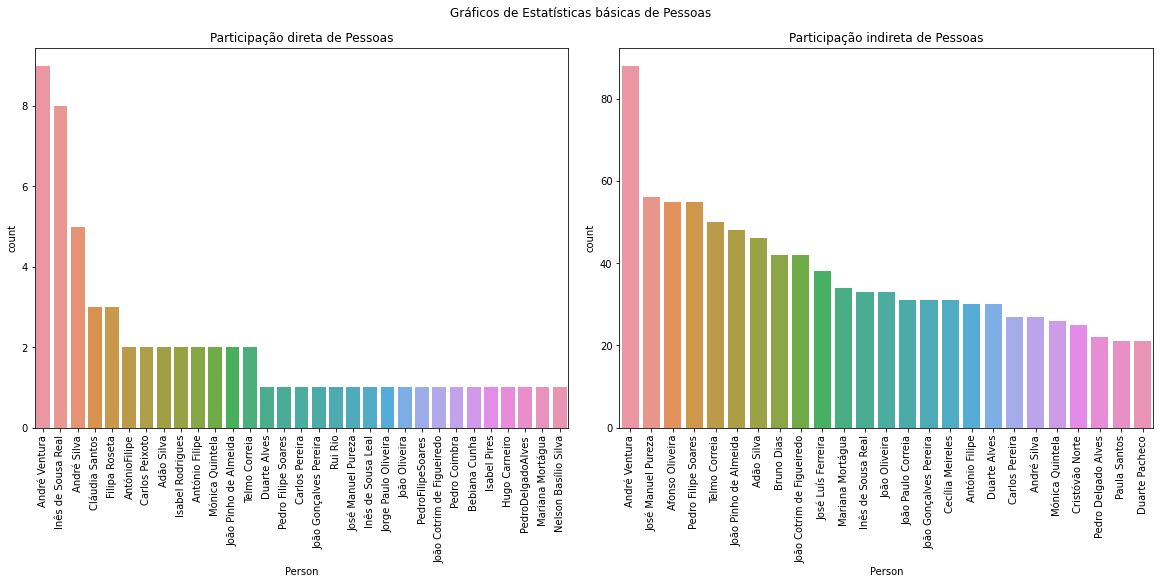

In [5]:
#@title #**Estatísticas gerais das pessoas** { display-mode: "form" }

def people_statistics(direct_citations, indirect_citations, number=25):
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(16,8))
    fig.suptitle('Gráficos de Estatísticas básicas de Pessoas')
    axs[0].set_title('Participação direta de Pessoas')
    axs[1].set_title('Participação indireta de Pessoas')
    sns.countplot(ax=axs[0], x='Person', data= direct_citations, order=direct_citations['Person'].value_counts().index)
    sns.countplot(ax=axs[1], x='Person', data= indirect_citations[-(indirect_citations['Person'] == 'Presidente')],
                  order=indirect_citations['Person'].value_counts().iloc[:number].index)
    axs[0].tick_params(axis='x', rotation=90)
    axs[1].tick_params(axis='x', rotation=90)
    plt.show()

people_statistics(direct_citations, indirect_citations)

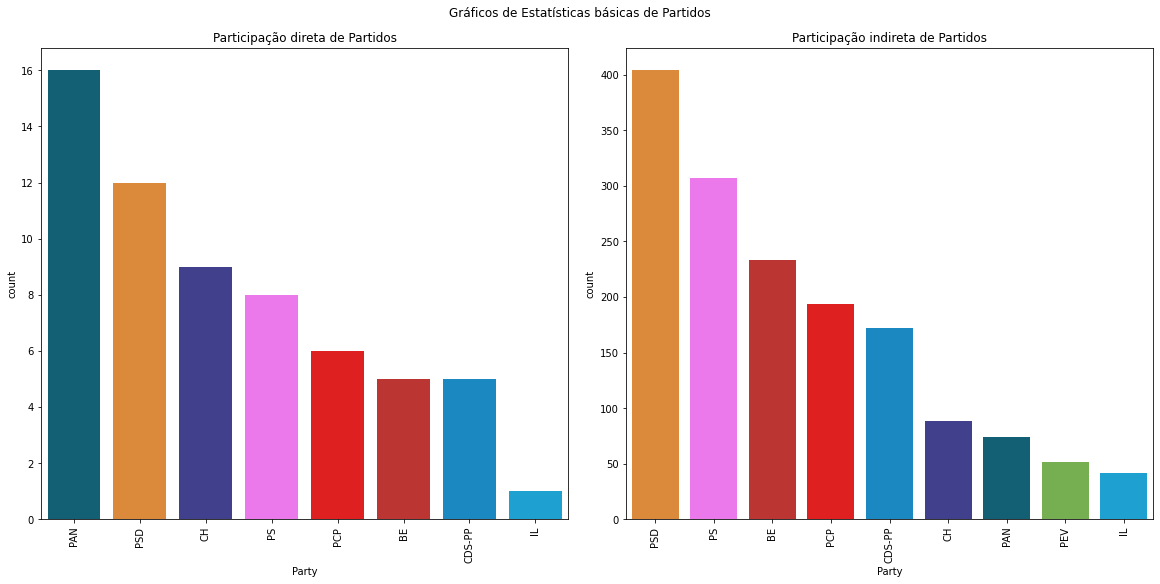

In [6]:
#@title #**Estatísticas gerais dos partidos** { display-mode: "form" }

def parties_statistics(direct_citations, indirect_citations, infos=load_infos()):
    
    party_colors = {}
    for party in infos:
        party_colors[party] = infos[party]['color']
    
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(16,8))
    fig.suptitle('Gráficos de Estatísticas básicas de Partidos')
    axs[0].set_title('Participação direta de Partidos')
    axs[1].set_title('Participação indireta de Partidos')

    sns.countplot(ax=axs[0], x='Party',
                  data= direct_citations, palette=party_colors,
                  order=direct_citations['Party'].value_counts().index)
    
    sns.countplot(ax=axs[1], x='Party', 
                  data= indirect_citations, palette=party_colors,
                  order=indirect_citations['Party'].value_counts().index)

    axs[0].tick_params(axis='x', rotation=90)
    axs[1].tick_params(axis='x', rotation=90)
    
    plt.show()

parties_statistics(direct_citations, indirect_citations)

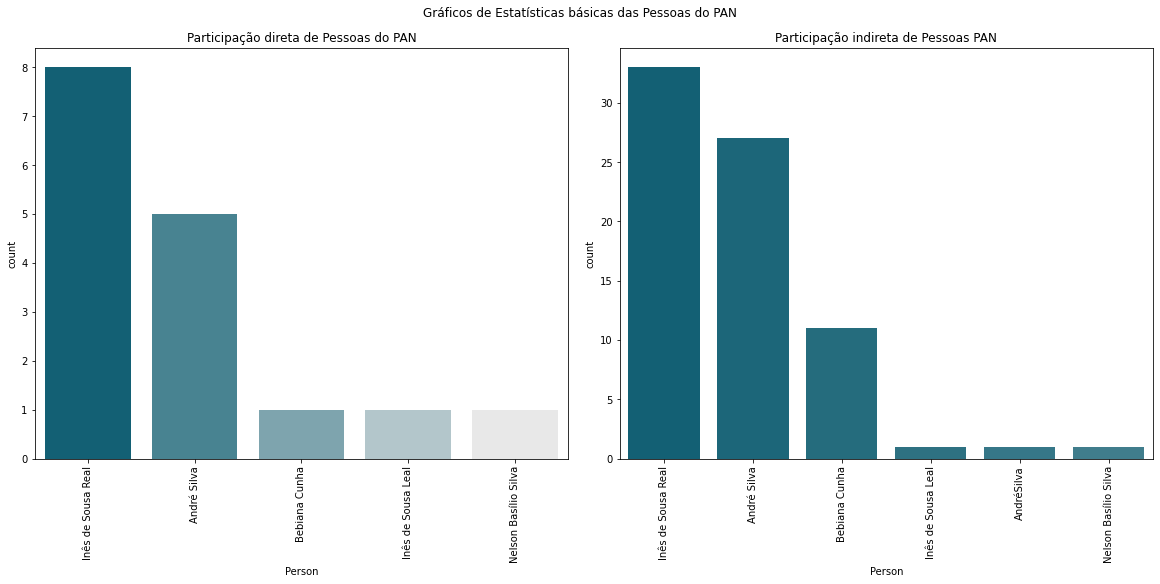

In [7]:
#@title #**Estatísticas das pessoas dos partidos** {run: "auto", display-mode: "form" }

def persons_byparty_statistics(direct_citations, indirect_citations, party, number=25, infos=load_infos()):
    direct_party = direct_citations.loc[direct_citations['Party'] == party]
    indirect_party = indirect_citations.loc[indirect_citations['Party'] == party]

    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(16,8))
    fig.suptitle('Gráficos de Estatísticas básicas das Pessoas do {}'.format(party))
    axs[0].set_title('Participação direta de Pessoas do {}'.format(party))
    axs[1].set_title('Participação indireta de Pessoas {}'.format(party))

    party_color = infos[party]['color']
    
    if len(direct_party) >= number:
        cmap = LinearSegmentedColormap.from_list('My_cmap', colors=['#E8E8E8', party_color], N=number)
        cmap = [rgb2hex(cmap(i)) for i in range(cmap.N)]
        cmap = cmap[::-1]
        sns.countplot(ax=axs[0], x='Person',
                data= direct_party,
                palette=cmap,
                order=direct_party['Person'].value_counts().iloc[:number].index)
    elif len(direct_party) > 0:
        cmap = LinearSegmentedColormap.from_list('My_cmap', colors=['#E8E8E8', party_color], N=len(direct_party['Person'].unique()))
        cmap = [rgb2hex(cmap(i)) for i in range(cmap.N)]
        cmap = cmap[::-1]
        sns.countplot(ax=axs[0], x='Person',
                data= direct_party,
                palette=cmap,
                order=direct_party['Person'].value_counts().iloc[:number].index)
    else:
        axs[0].text(
            x=1.75/15.5,
            y=0.5,
            s='Dados insuficientes para geração do gráfico',
            fontdict = dict(size=16, color='black', fontweight='bold')
        )
        
    if len(indirect_party) >= number:
        cmap = LinearSegmentedColormap.from_list('My_cmap', colors=['#E8E8E8', party_color], N=number)
        cmap = [rgb2hex(cmap(i)) for i in range(cmap.N)]
        cmap = cmap[::-1]
        sns.countplot(ax=axs[1], x='Person',
                data= indirect_party,
                palette=cmap,
                order=indirect_party['Person'].value_counts().iloc[:number].index)
    else:
        cmap = LinearSegmentedColormap.from_list('My_cmap', colors=['#E8E8E8', party_color], N=len(indirect_party['Person'].unique()))
        cmap = [rgb2hex(cmap(i)) for i in range(cmap.N)]
        cmap = cmap[::-1]
        sns.countplot(ax=axs[1], x='Person',
                data= indirect_party,
                palette=cmap,
                order=indirect_party['Person'].value_counts().iloc[:number].index)
    
    axs[0].tick_params(axis='x', rotation=90)
    axs[1].tick_params(axis='x', rotation=90)
    plt.show()

#@markdown Selecione um partido
partido = 'PAN' #@param['BE', 'CDS-PP', 'CH', 'IL', 'PAN', 'PCP', 'PEV', 'PS', 'PSD']
persons_byparty_statistics(direct_citations, indirect_citations, partido)

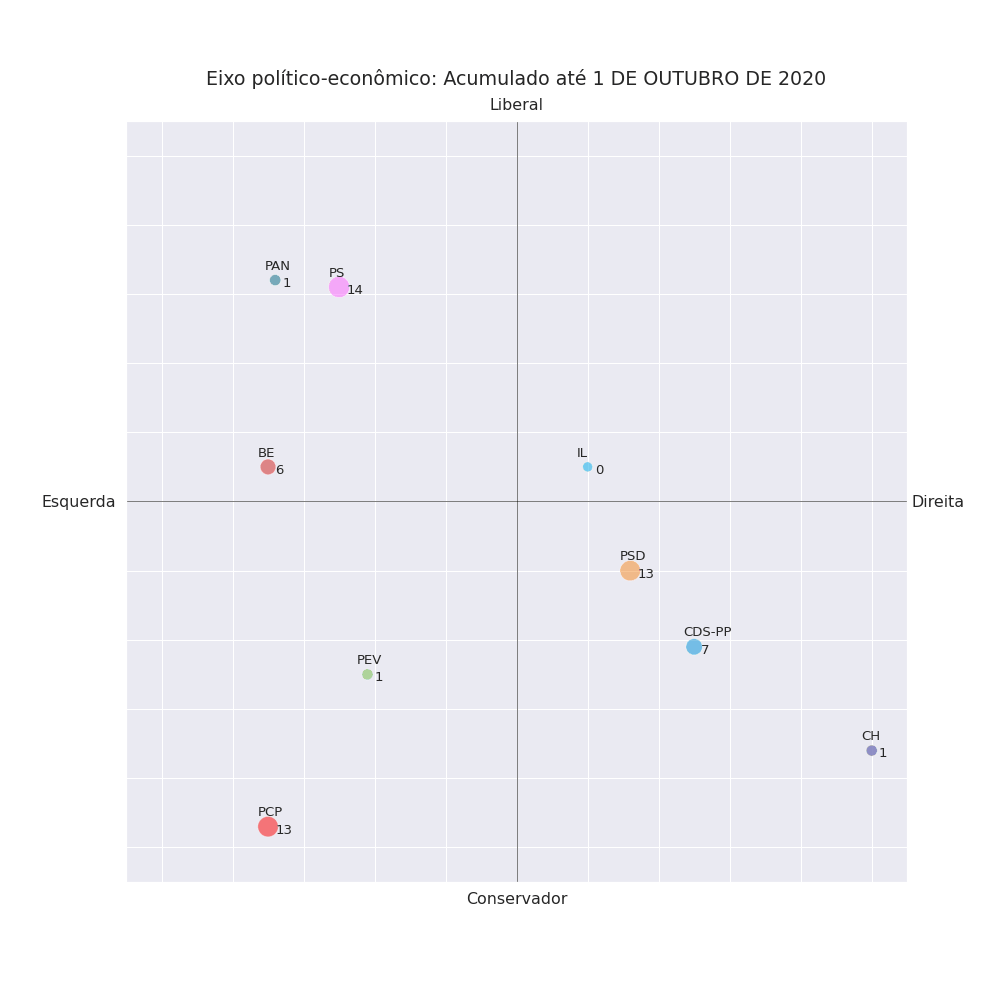

In [8]:
#@title #**Gráfico político-econômico animado das citações diretas** {run: "auto", display-mode: "form" }

def create_dataframes(citations, infos=load_infos()):
    df_dict = {}
    dates = citations['Date'].unique().tolist()
    grouped = citations.groupby(citations['Date'])
    
    for i in range(len(dates)):

        group = grouped.get_group(citations['Date'].unique().tolist()[i])

        df_dict[str(dates[i])] = {            
            'Party' : [],
            'Count' : [],
            'Color' : [],
            'Orientation' : [],
            'Image' : [],
            'X_coordinate' : [],
            'Y_coordinate' : [],
        }
        
        for party in infos:
            
            df_dict[str(dates[i])]['Party'].append(party)
            df_dict[str(dates[i])]['Count'].append(len(group.loc[group['Party'] == party]))
            df_dict[str(dates[i])]['Color'].append(infos[party]['color'])
            df_dict[str(dates[i])]['Orientation'].append(infos[party]['orientation'])
            df_dict[str(dates[i])]['Image'].append(infos[party]['url_image'])
            df_dict[str(dates[i])]['X_coordinate'].append(infos[party]['coordinates'][0])
            df_dict[str(dates[i])]['Y_coordinate'].append(infos[party]['coordinates'][1])

        df_dict[str(dates[i])] = pd.DataFrame(df_dict[str(dates[i])])

    dates = [str(date) for date in dates]
    dates.sort()

    return df_dict, dates

def create_graph(df, date, normalization=(0, 405)):
    colors = {}

    for i in range(len(df)):
        colors[df['Party'][i]] = df['Color'][i]

    sns.set_style('darkgrid')
    sns.set_context('paper')
    sns.set(font_scale=1.1)

    plt.figure(figsize=(14, 14))
    ax = sns.scatterplot(x='X_coordinate', y='Y_coordinate', data=df,
                         palette=colors, hue='Party', size='Count', 
                         alpha=0.5, sizes=(100, 10000),
                         size_norm=(normalization[0], normalization[1]))

    ax.set_title('Eixo político-econômico: Acumulado até ' + str(date), y=1.04, fontsize='x-large')

    ax.set(xlim=(-5.5, 5.5), ylim=(-5.5, 5.5))
    
    ax.axhline(y=0, linewidth=0.5, color='black')
    ax.axvline(x=0, linewidth=0.5, color='black')

    for i in range(len(df)):
        ax.annotate(df['Party'][i],
                    xy=(df['X_coordinate'][i], df['Y_coordinate'][i]),
                    xycoords='data',
                    xytext=(df['X_coordinate'][i]-0.15, df['Y_coordinate'][i]+0.15),
                    )
        ax.annotate(df['Count'][i],
            xy=(df['X_coordinate'][i], df['Y_coordinate'][i]),
            xycoords='data',
            xytext=(df['X_coordinate'][i]+0.1, df['Y_coordinate'][i]-0.1),
            )
    
    ax.legend(fancybox=True, shadow=True)

    plt.xticks(np.arange(-5, 6, 1), 5*['']+['Conservador']+5*[''], fontsize='large')
    plt.yticks(np.arange(-5, 6, 1), 5*['']+['Esquerda']+5*[''], fontsize='large')

    labelx = ax.set_xlabel('Liberal', fontsize='large')
    ax.xaxis.set_label_coords(0.5, 1.03)

    labely = ax.set_ylabel('Direita', fontsize='large', rotation='horizontal')
    ax.yaxis.set_label_coords(1.04, 0.489)
    
    ax.get_legend().remove()
    
    plt.close()

    return ax.get_figure()

def acumulative(citations_dict, citations_dates):

    acumulative_dict = copy.deepcopy(citations_dict)

    for i in range(1, len(citations_dates)):
        acumulative_dict[citations_dates[i]]['Count'] += acumulative_dict[citations_dates[i-1]]['Count']
    
    return acumulative_dict

def get_normalization(citations_dict, citations_dates):
    return (citations_dict[citations_dates[0]]['Count'].min(), citations_dict[citations_dates[-1]]['Count'].max())

def clean_acumulative(acumulative_dict, acumulative_dates):

    clean_dict = copy.deepcopy(acumulative_dict)

    last_df = clean_dict[acumulative_dates[-1]]
    null_values = []

    for i in range(len(last_df['Party'])):
        if last_df['Count'][i] == 0:
            null_values.append(last_df['Party'][i])

    for date in acumulative_dates:
        for party in null_values:
            clean_dict[date] = clean_dict[date][clean_dict[date]['Party'] != party]
        clean_dict[date].reset_index(drop=True, inplace=True)    
    return clean_dict

def create_gif(citations_dict, citations_dates, folder_name='citations', gif_name='citations', duration=1):
    acumulative_dict = acumulative(citations_dict, citations_dates)
    clean_dict = clean_acumulative(acumulative_dict, citations_dates)
    norm = get_normalization(clean_dict, citations_dates)

    graph_images = []
    png_images = []
    
    origin_path = os.getcwd()
    os.makedirs(os.path.join(origin_path, folder_name), exist_ok=True)
    os.chdir(os.path.join(origin_path, folder_name))

    for i in range(len(citations_dates)):
        graph_images.append(create_graph(clean_dict[citations_dates[i]], citations_dates[i], norm))
        graph_images[i].savefig(citations_dates[i] + '.png')
        png_images.append(imageio.imread(citations_dates[i] + '.png'))

    imageio.mimsave(gif_name+'.gif', png_images, format='GIF', duration=1)

    display(Image(open(os.path.join(origin_path, folder_name, gif_name+'.gif'),'rb').read()))

    os.chdir(origin_path)

indirect_dict, indirect_dates = create_dataframes(indirect_citations)
create_gif(indirect_dict, indirect_dates, 'indirect-citations', 'indirect-citations')

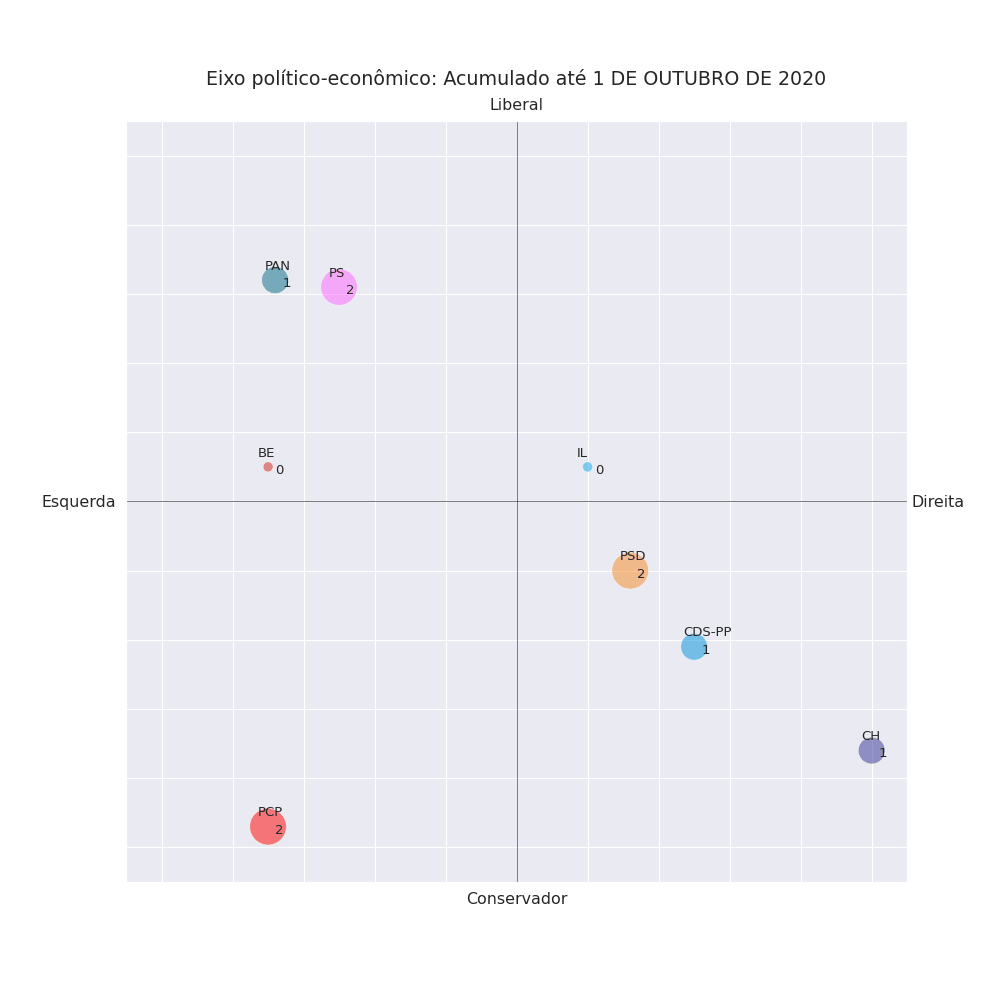

In [9]:
#@title #**Gráfico político-econômico animado das citações diretas** {run: "auto", display-mode: "form" }

direct_dict, direct_dates = create_dataframes(direct_citations)
create_gif(direct_dict, direct_dates, 'direct-citations', 'direct-citations')